# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к Data Mining этот процесс называется Extract-Transform-Load

In [1]:
# !pip install -r requirements.txt

In [2]:
# !pip3 install -r requirements.txt

In [40]:
import vk
import folium
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

Нам потребуется загрузить информацию о местах, в которых совершаются чекины, иначе говоря провести сбор данных (data collection). [Ссылка на ВК для разработчиков](https://vk.com/dev)

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в VK в качестве разработчика и создать свое [приложение](https://vk.com/apps?act=manage). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Далее вам потребуется создать токен авторизации, чтобы получать доступ к API. Этот токен необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в VK API можно почитать [по ссылке](https://vk.com/dev/first_guide), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [2]:
ACCESS_TOKEN = "79fa181d79fa181d79fa181dea79acbda9779fa79fa181d20237d54959d64fbbfea5aff"
session = vk.Session(access_token=ACCESS_TOKEN)
vkapi = vk.API(session=session)

### Всегда привык обращаться к вк спомощью обычного request  Это связано с тем, что на одной из подработок пришлось написать быстрый парсер вк и метод "execute" работал не так как я хотел ( решил, что проще весь интерфейс  написать самому, чем переписывать куски с vkapi )

In [4]:
import request, json

In [5]:
#Получаем access token
ACCESS_TOKEN = 'j0U04UMHTnSw2qmiPCIp'
url = 'https://oauth.vk.com/authorize?client_id=5678516&response_type=token&v=5.62&state=123456'
print(url)

https://oauth.vk.com/authorize?client_id=5678516&response_type=token&v=5.62&state=123456


Заходим по ссылке, копируем ACCESS_TOKEN и вставляем в следующий блок

(когда я писал тот парсер, для автоматизации, получал его через vkapi, но зачем усложнять  если можно сделать просто)

In [6]:
ACCESS_TOKEN = 'bbcc0b77505a478ade480471be99e8e1d03856d0588d498d208cf6472701f834be4c4e5c1a315a5022184'

In [7]:
group_name = 'overhear_msu'
import json, requests
url = 'https://api.vk.com/method/groups.getMembers?group_id='+group_name+'&fields=status&access_token='+ACCESS_TOKEN
resp = requests.get(url=url)
data = json.loads(resp.text)
number_of_people = data['response']['count']
print("количество подписчиков: "+str(number_of_people))

количество подписчиков: 53822


In [8]:
import time, sys
from tqdm import tqdm
def get_place_single_batch(placeIdlst):
    placeIdlst = ','.join([str(i) for i in placeIdlst])
    url = 'https://api.vk.com/method/places.getById?places='+placeIdlst+'&access_token='+ACCESS_TOKEN
    resp = requests.get(url=url)
    data = json.loads(resp.text)
    if 'response' in data:
        return data['response']
    else: 
        time.sleep(3)
        return False
    
def get_place_info(idx=5, batch_size = 500):
    g = []
    for i in tqdm(range(1,idx+1,batch_size)):
        try:         
            placeId = list(range(i, min(i+batch_size, idx+1)))
            data = get_place_single_batch(placeId)

            if data:
                g.extend(data)
            else:
                data = get_place_single_batch(placeId)
                if  data:
                    g.extend(data)
        except:
            return g
    return g

In [35]:
g = get_place_info(idx=15000, batch_size=500)

100%|██████████| 30/30 [00:14<00:00,  1.36it/s]


In [49]:
df = {}
for j in g:
    df[j['pid']] = j
df = pd.DataFrame(df).T
del df['pid']

Предположим, что мы хотим понять несколько фактов о выборке объектов с id от 1 до 15000.
Помогите нам это сделать.
А вот и сами факты:
1. Провизуализируйте на карте все объекты которые находятся в Москве? Где больше объектов, в центре или на окраине?
2. Посчитайте количество объектов разного типа. Постройте распределение? Объектов какого типа больше в данной выборке?
3. Посчитайте распределение числа чекинов по всей выборке. Визуализируйте его.
4. Постройте box plot по числу чекинов для каждого типа объектов.
5. Преобразуйте поле created в datetime. Как давно были созданы объекты? Сколько объектов существует больше года? 

Не забудьте сохранить данную выборку, в будущем она вам понадобится.

<h1><center>1. Визуализация</center></h1>
Нарисуем точки на карте москвы код города 1  [*ссылка на источник](https://vk.com/dev.php?method=database.getCities)

In [13]:
# !pip install geopy
# !sudo pip install --upgrade matplotlib

#### Самая красивая библиотека для визуалиации которую я нашел

(ее отличие от gmaps в том, что не надо получать api key и результат это что-то типо сложной ссылки на mapsgoogle и она красивее чем basemap из matplotlib)

In [14]:
# !pip3 install gmplot

In [15]:
moscow = df[df['city']==1]

In [16]:
import gmplot
gmap = gmplot.GoogleMapPlotter(55.7506, 37.6154, 12) #Координаты кремля и степень увеличения
gmap.heatmap(moscow['latitude'][:2000], moscow['longitude'][:2000])
gmap.heatmap(moscow['latitude'][2000:], moscow['longitude'][2000:])
gmap.draw("result.html")

[ссылка на результат](result.html)  (если она не открывается, ее можно открыть вручную, там красиво и все удобно масштабируется, это html файл, с javascript запросом к google) 

![title](image/map.png)

![title](image/map_small.png)

<h3><center> Да, большая часть объектов внутри садового кольца</center></h3>



<h1><center>2. Типы объектов</center></h1>

#### Полная выборка

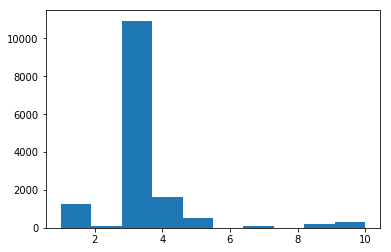

3	: 10936	Ресторан
4	: 1626	Клуб
1	: 1242	Дом
5	: 512	Кинотеатр
10	: 299	Вокзал
9	: 183	Аэропорт
2	: 90	Работа
7	: 90	Развлечения
8	: 13	Магазин
6	: 9	Бар


In [53]:
# del moscow # Удалим ненужное
df['type'].hist(bins = 10)
plt.show()

def get_places():
    url = 'https://api.vk.com/method/places.getTypes?&access_token='+ACCESS_TOKEN
    resp = requests.get(url=url)
    data = json.loads(resp.text)
    places = {t['tid'] : t['title'] for t in data['response']}
    return places
places = get_places()
# print("\n".join([str(t['tid'])+'\t'+t['title']+'\t'+places[t['tid']] for t in data['response']]))

from collections import Counter
print("\n".join([str(i)+'\t: '+str(k)+'\t'+places[i] for i,k in sorted(Counter(df['type']).items(), key = lambda x:-x[1])]))

#### Только Москва

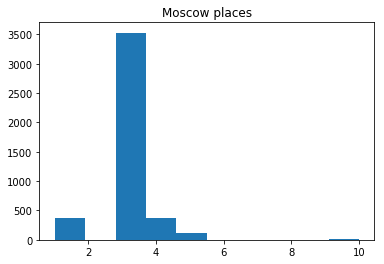

3	: 3529	Ресторан
4	: 372	Клуб
1	: 369	Дом
5	: 112	Кинотеатр
10	: 10	Вокзал
6	: 5	Бар
7	: 5	Развлечения
9	: 4	Аэропорт
8	: 3	Магазин


In [28]:
# del moscow # Удалим ненужное
plt.title('Moscow places')
plt.hist(list(df[df['city']==1]['type']), bins = 10)
plt.show()

def get_places():
    url = 'https://api.vk.com/method/places.getTypes?&access_token='+ACCESS_TOKEN
    resp = requests.get(url=url)
    data = json.loads(resp.text)
    places = {t['tid'] : t['title'] for t in data['response']}
    return places
places = get_places()

from collections import Counter
print("\n".join([str(i)+'\t: '+str(k)+'\t'+places[i] for i,k in sorted(Counter(df[df['city']==1]['type']).items(), key = lambda x:-x[1])]))

#### Только Питер

In [33]:
df

dtype('O')

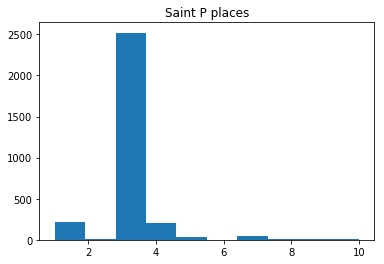

3	: 2520	Ресторан
1	: 219	Дом
4	: 204	Клуб
7	: 41	Развлечения
5	: 38	Кинотеатр
2	: 12	Работа
9	: 8	Аэропорт
10	: 6	Вокзал
8	: 5	Магазин


In [54]:
# del moscow # Удалим ненужное
plt.title('Saint P places')
plt.hist(list(df[df['city']==2]['type']), bins = 10)
plt.show()

def get_places():
    url = 'https://api.vk.com/method/places.getTypes?&access_token='+ACCESS_TOKEN
    resp = requests.get(url=url)
    data = json.loads(resp.text)
    places = {t['tid'] : t['title'] for t in data['response']}
    return places
places = get_places()
# print("\n".join([str(t['tid'])+'\t'+t['title']+'\t'+places[t['tid']] for t in data['response']]))

from collections import Counter
print("\n".join([str(i)+'\t: '+str(k)+'\t'+places[i] for i,k in sorted(Counter(df[df['city']==2]['type']).items(), key = lambda x:-x[1])]))

In [354]:
print("Все места:")
print("\n".join([str(t[0])+'\t'+t[1] for t in places.items()]))

Все места:
1	Дом
2	Работа
3	Ресторан
4	Клуб
5	Кинотеатр
6	Бар
7	Развлечения
8	Магазин
9	Аэропорт
10	Вокзал
11	Отель
12	Кафе
13	Бистро
14	Пиццерия
15	Бассейн
16	Тренажерный зал
17	Учебное заведение
18	Музей
19	Театр
20	Парк
21	Другое


##### 183 Аэропорта, странно

In [368]:
df[(df['city']==1) & (df['type'] == 9)]

,address,checkins,city,country,created,icon,latitude,longitude,title,type,updated
13042,NaN,114,1,1,1280860290,https://vk.com/images/places/airport.png,55.6172,38.06,Быково,9,1504520494
13059,NaN,7754,1,1,1280860290,https://vk.com/images/places/airport.png,55.4088,37.9063,Домодедово,9,1506938514
13171,NaN,5347,1,1,1280860354,https://vk.com/images/places/airport.png,55.9726,37.4146,Шереметьево,9,1506890238
13198,NaN,1988,1,1,1280860354,https://vk.com/images/places/airport.png,55.5915,37.2615,Внуково,9,1506176874


In [367]:
df[(df['city']==2) & (df['type'] == 9)]

,address,checkins,city,country,created,icon,latitude,longitude,title,type,updated
13112,NaN,232,2,1,1280860354,https://vk.com/images/places/airport.png,59.8003,30.2625,Пулково,9,1501813507
13160,NaN,11,2,1,1280860354,https://vk.com/images/places/airport.png,59.98,30.5856,Ржевка,9,1499296758
14138,Варшавская ул. 44,0,2,1,1280867208,https://vk.com/images/places/airport.png,59.8672,30.3139,Музыкальная Школа,9,NaN
14140,Варшавская ул. 44,1,2,1,1280867209,https://vk.com/images/places/airport.png,59.8672,30.3139,Музыкальная Школа,9,1280867299
14142,Варшавская ул. 44,0,2,1,1280867210,https://vk.com/images/places/airport.png,59.8672,30.3139,Музыкальная Школа,9,NaN
14144,Варшавская ул. 44,0,2,1,1280867210,https://vk.com/images/places/airport.png,59.8672,30.3139,Музыкальная Школа,9,NaN
14145,Варшавская ул. 44,0,2,1,1280867210,https://vk.com/images/places/airport.png,59.8672,30.3139,Музыкальная Школа,9,NaN
14147,Варшавская ул. 44,0,2,1,1280867211,https://vk.com/images/places/airport.png,59.8672,30.3139,Музыкальная Школа,9,NaN


In [393]:
print("Количество городов в выборке : "+str(len(df['city'].unique())))

Количество городов в выборке : 382


##### Ничего странного, наверное их вносили первыми

<h1><center>3. Распределение числа чекинов по всей выборке</center></h1>

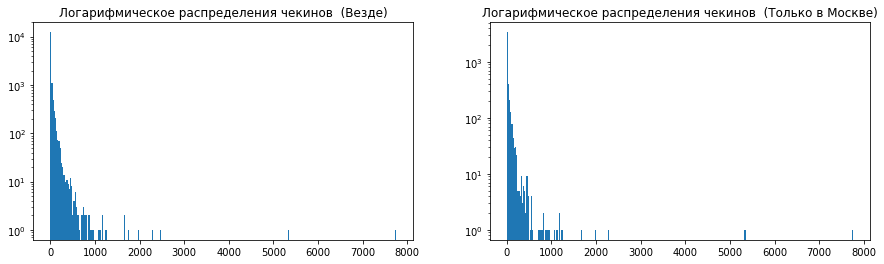

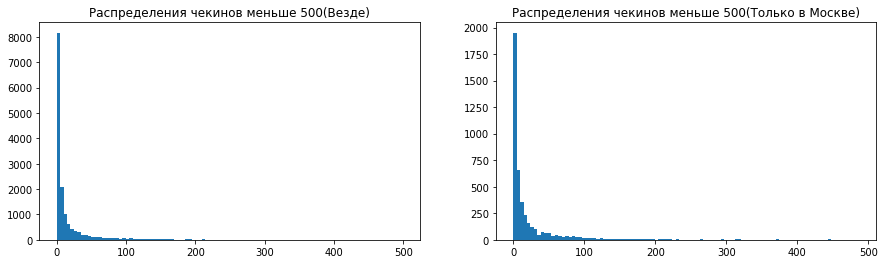

In [423]:
# plt.title("Логарифмическое чило распределения чекинов")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.set_title("Логарифмическое распределения чекинов  (Везде)")
ax1.hist(df['checkins'], bins = 300, log = True)

ax2.set_title("Логарифмическое распределения чекинов  (Только в Москве)")
ax2.hist(df[df['city'] == 1]['checkins'], bins = 300, log = True)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.set_title("Распределения чекинов меньше 500(Везде)")
ax1.hist(list(filter(lambda x:x<500, df['checkins'])), bins = 100)

ax2.set_title("Распределения чекинов меньше 500(Только в Москве)")
ax2.hist(list(filter(lambda x:x<500, df[df['city'] == 1]['checkins'])), bins = 100)
plt.show()

#####  Распределение чекинов похоже на сумму различных типов распределений
####   Нарисуем все распределения по типам 

Распределение по типам


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


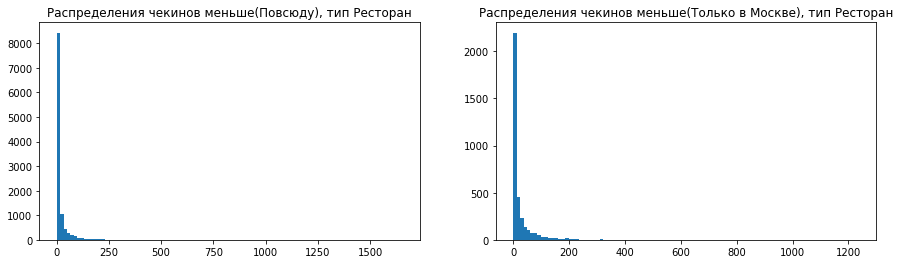

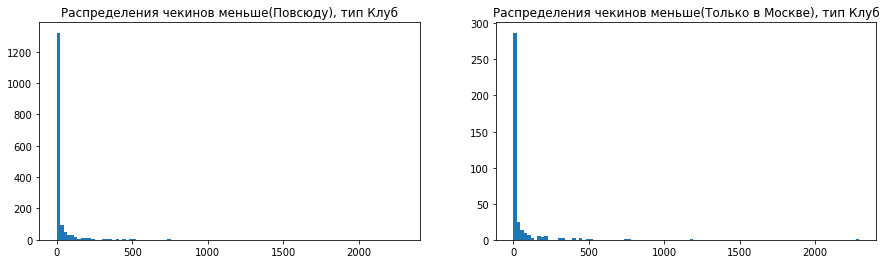

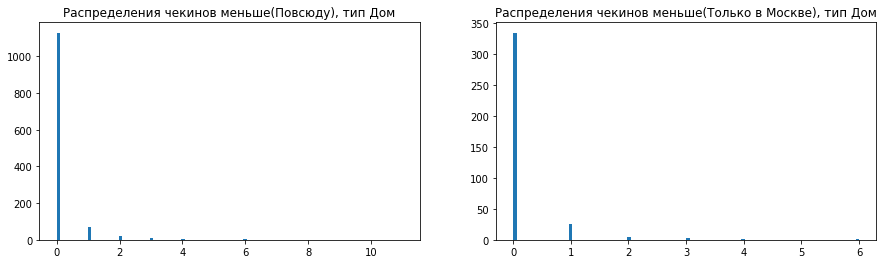

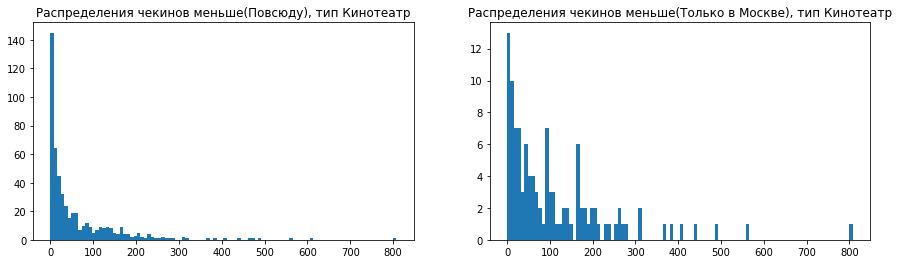

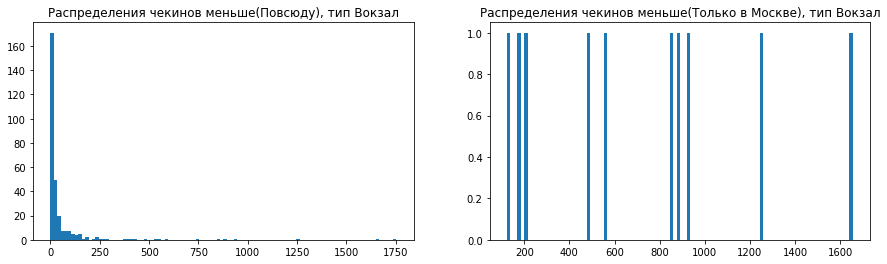

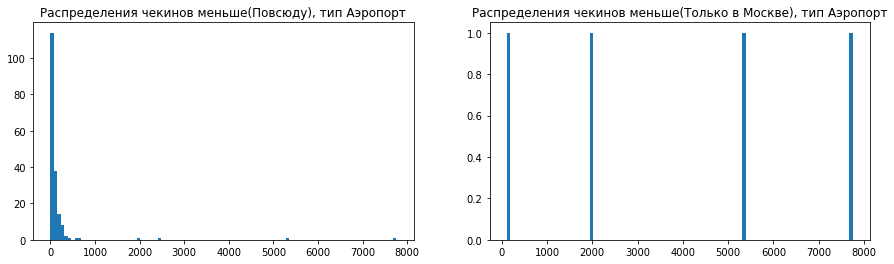

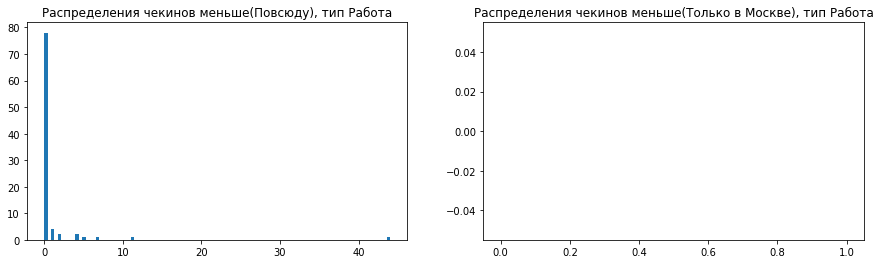

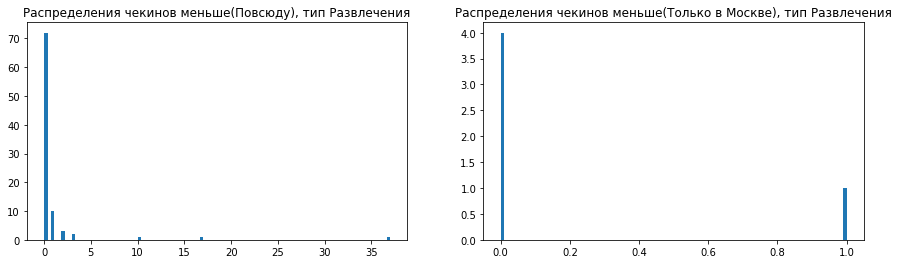

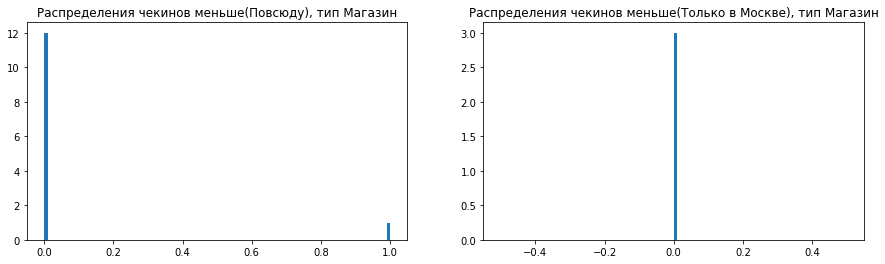

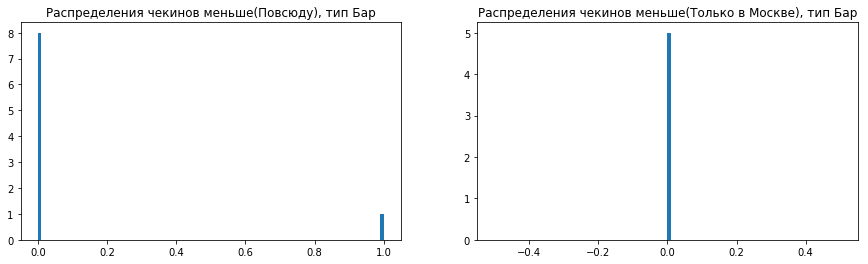

In [466]:
print("Распределение по типам")
for i in sorted(df['type'].unique(), key = lambda x:-len(df[df['type']==x])):
    place = places[i]
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
    ax1.set_title("Распределения чекинов меньше(Повсюду), тип "+place)
    ax1.hist(list(filter(lambda x:x<100000, df[df['type']==i]['checkins'])), bins = 100)

    ax2.set_title("Распределения чекинов меньше(Только в Москве), тип "+place)
    ax2.hist(list(filter(lambda x:x<100000, df[df['type']==i][df['city'] == 1]['checkins'])), bins = 100)
plt.show()

## Нарисуем их на карте для Москвы

In [541]:
moscow = df[df['city']==1][df['checkins']==0]
import gmplot
gmap = gmplot.GoogleMapPlotter(55.7506, 37.6154, 12) #Координаты кремля и степень увеличения
gmap.scatter(moscow['latitude'][:2000], moscow['longitude'][:2000])
gmap.draw("result_checkin_small.html")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Нулевые места по чекинам в Москве

![title](image/map_top_small.png)

In [543]:
moscow = df[df['city']==1][df['checkins']>100]
import gmplot
gmap = gmplot.GoogleMapPlotter(55.7506, 37.6154, 12) #Координаты кремля и степень увеличения
gmap.scatter(moscow['latitude'][:2000], moscow['longitude'][:2000])
gmap.draw("result_checkin.html")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Топ самых посещаемых мест в Москве

![title](image/map_top.png)

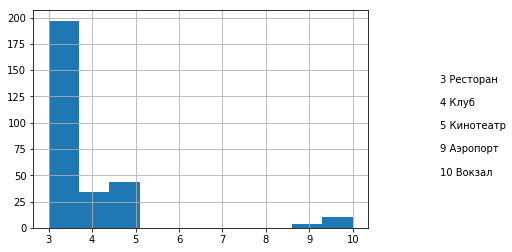

In [544]:
moscow['type'].hist()
plt.text(12,50,'\n\n'.join([str(i)+' '+str(places[i]) for i in sorted(moscow['type'].unique())]))
plt.show()

In [525]:
print("Самые популярные места в Москве")
for i in sorted(moscow['checkins'], reverse = True)[:20]:
    name = str(moscow[moscow['checkins']==i]['title'].get_values()[0])
    print(name+' '*(30-len(name))+str(i))

Самые популярные места в Москве
Домодедово                    7754
Шереметьево                   5347
Soho Rooms                    2291
Внуково                       1988
КАЗАНСКИЙ ВОКЗАЛ              1656
ЛЕНИНГРАДСКИЙ ВОКЗАЛ          1254
Starbucks                     1238
Kalina Bar                    1180
Пропаганда                    1179
Hard Rock Cafe                1113
Нескучный сад                 1066
КУРСКИЙ ВОКЗАЛ                931
Облака                        906
БЕЛОРУССКИЙ ВОКЗАЛ            880
ЯРОСЛАВСКИЙ ВОКЗАЛ            855
Vogue Cafe                    822
Октябрь                       808
Courvoisier Cafe              778
Arena Moscow                  765
Шестнадцать тонн              744


#### Это вокзалы, аэропорты и пафосные места где нищие делают фотографии (облака, soho)
#### Так как это данные вконтакте, навеное чекин собирается по подписям к фотографиям

In [538]:
print("Самые популярные места во всей выборке")
for i in sorted(df['checkins'], reverse = True)[:100]:
    temp = df[df['checkins']==i][['title', 'city']].get_values()[0]
    name = str(temp[0])+' '*(20-len(str(temp[0])))+str(temp[1])
    print(name+' '*(30-len(name))+str(i))

Самые популярные места во всей выборке
Домодедово          1         7754
Шереметьево         1         5347
Борисполь           7623      2478
Soho Rooms          1         2291
Внуково             1         1988
Московский вокзал   2         1753
КАЗАНСКИЙ ВОКЗАЛ    1         1656
Пулково-2           2         1655
ЛЕНИНГРАДСКИЙ ВОКЗАЛ1         1254
Starbucks           1         1238
Kalina Bar          1         1180
Пропаганда          1         1179
Hard Rock Cafe      1         1113
D'Lux               314       1094
Нескучный сад       1         1066
Паруса              2         971
КУРСКИЙ ВОКЗАЛ      1         931
Облака              1         906
БЕЛОРУССКИЙ ВОКЗАЛ  1         880
Avalon              314       869
ЯРОСЛАВСКИЙ ВОКЗАЛ  1         855
Vogue Cafe          1         822
Октябрь             1         808
Летний сад          2         797
Courvoisier Cafe    1         778
Arena Moscow        1         765
Шатер               2         755
Шестнадцать тонн    1       

In [547]:
sp = df[df['city']==2]
print("Самые популярные места в В питере")
for i in sorted(sp['checkins'], reverse = True)[:40]:
    name = str(sp[sp['checkins']==i]['title'].get_values()[0])
    print(name+' '*(30-len(name))+str(i))

Самые популярные места в В питере
Московский вокзал             1753
Пулково-2                     1655
Паруса                        971
Летний сад                    797
Шатер                         755
Эрмитаж                       706
Nebar                         650
Ладожский вокзал              592
Витебский вокзал              534
Новая Голландия               499
Терраса                       480
Азимут                        474
Del Mar                       453
Счастье                       416
Счастье                       416
Финляндский вокзал            414
На речке                      404
Ambassador                    394
Котельная «Камчатка»          366
Папанин                       364
Maximilian Brauhaus           343
Бегемот                       338
Летний дворец                 332
Две палочки                   323
Карл и Фридрих                308
James Cook                    301
Bali                          289
Саквояж для беременной шпионки284
Невский, 106

<h1><center>4. Построим box plot по числу чекинов для каждого типа объектов.</center></h1>

Распределение по типам


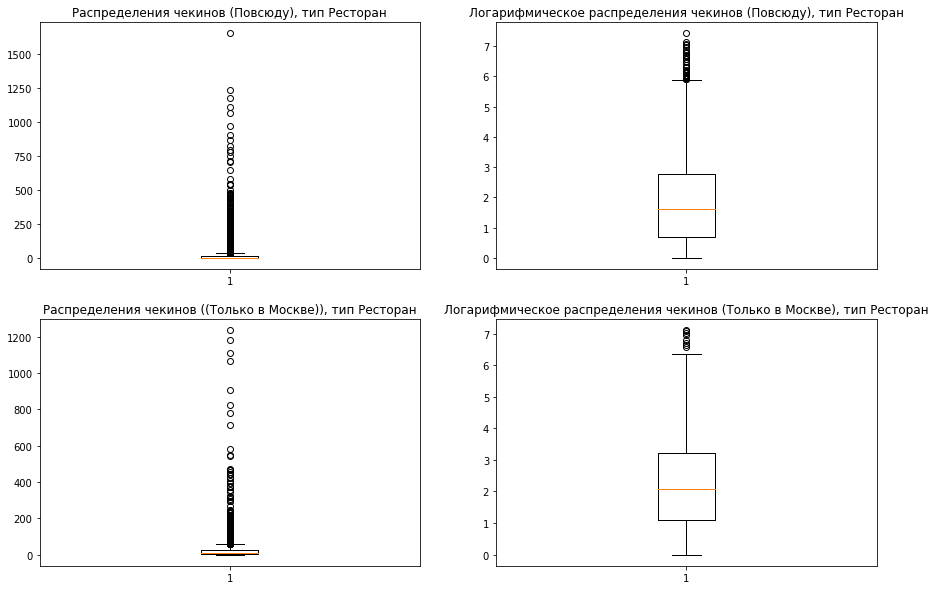

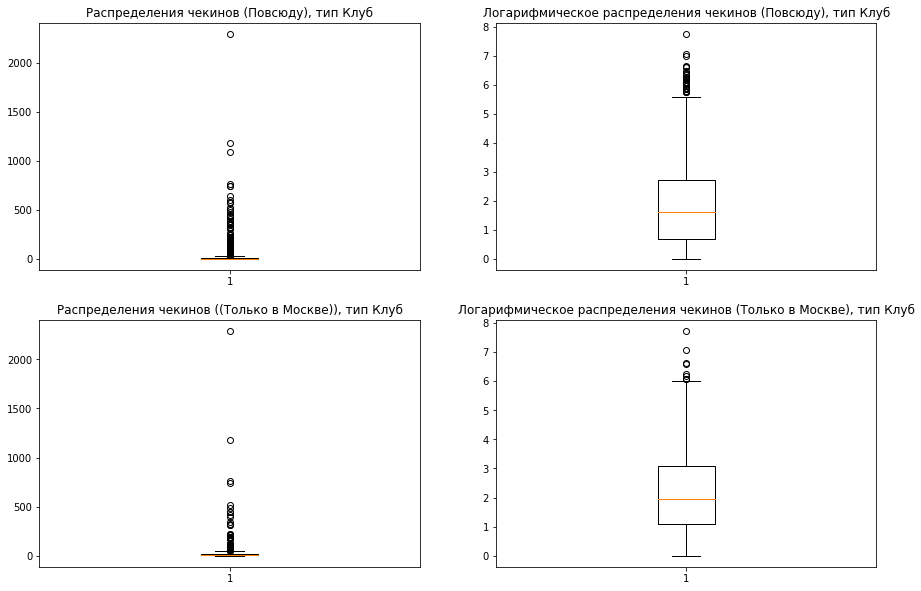

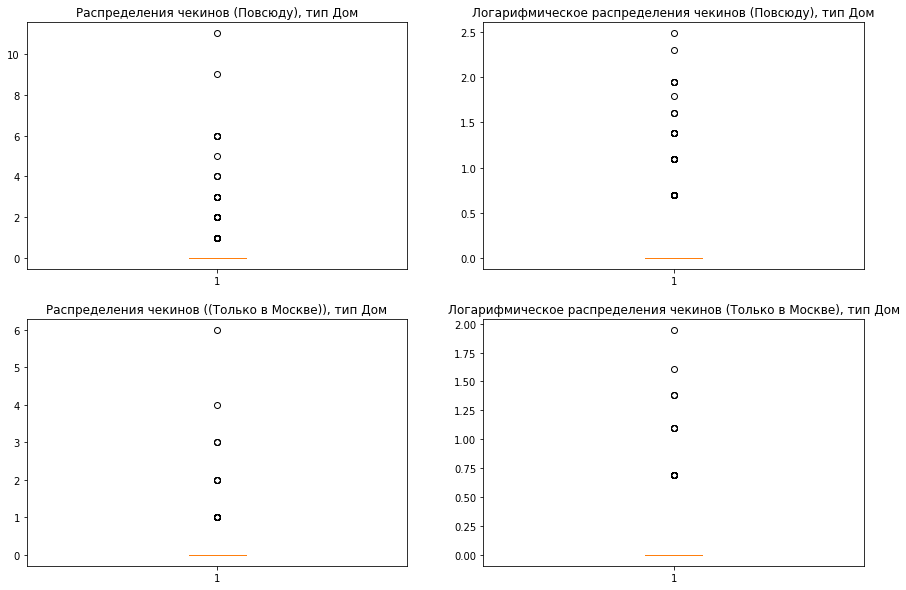

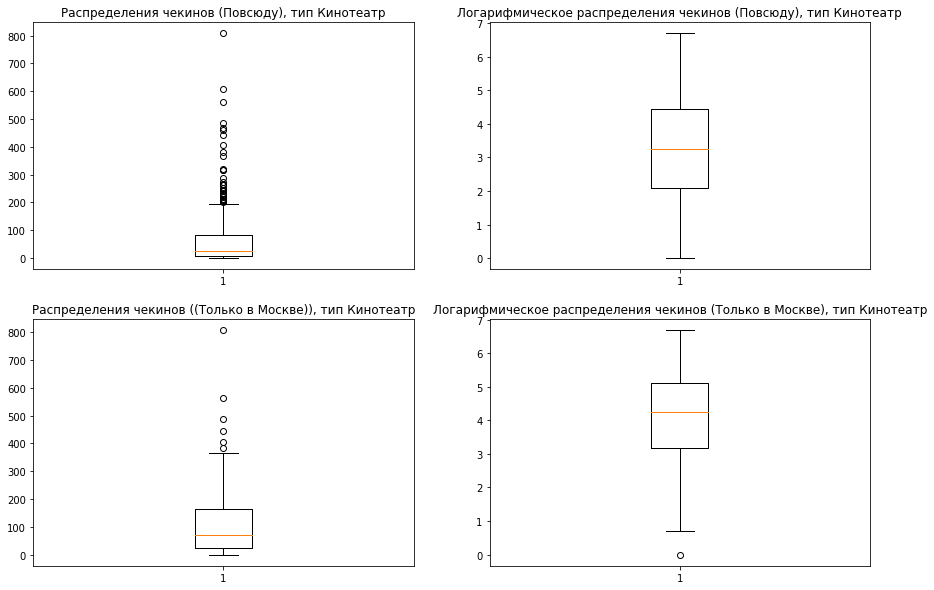

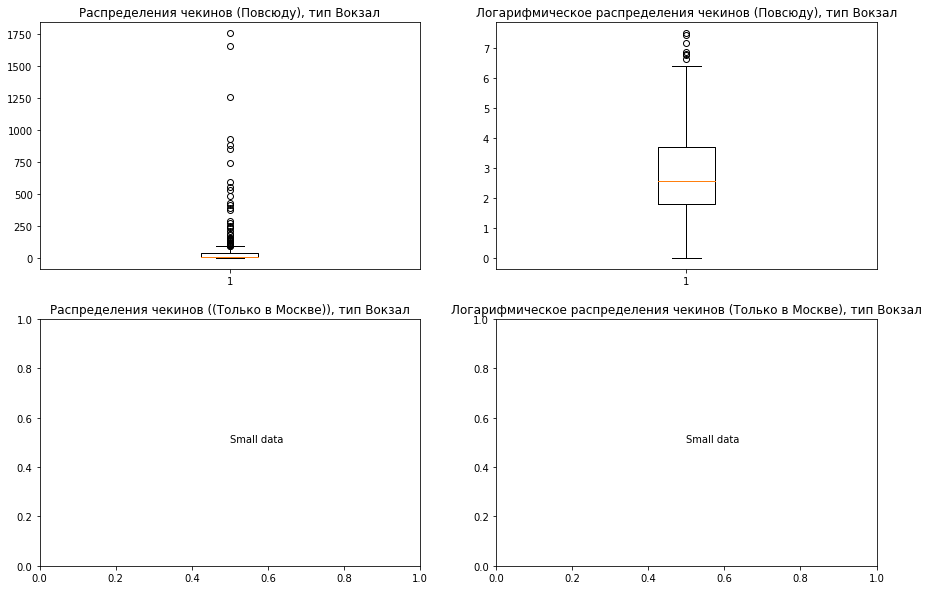

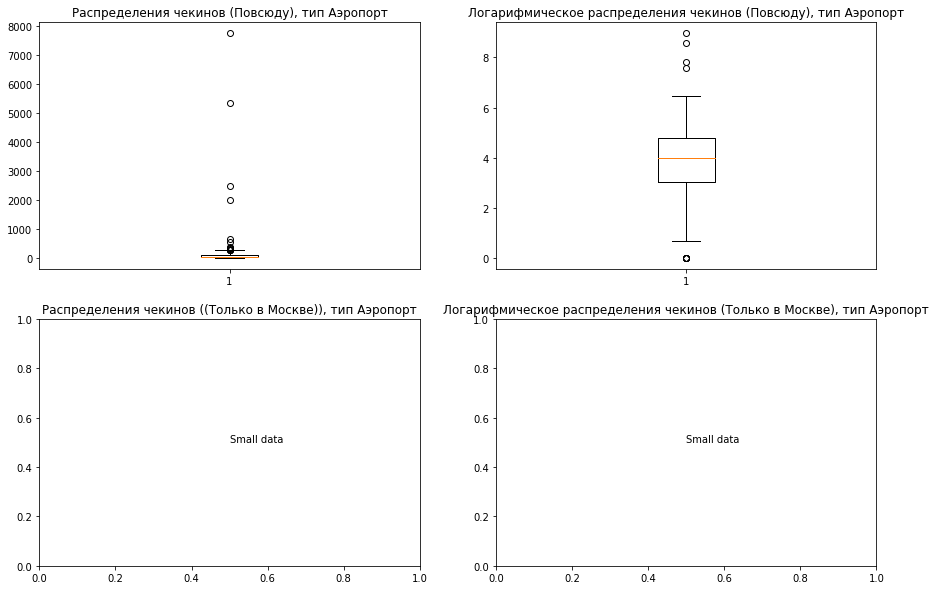

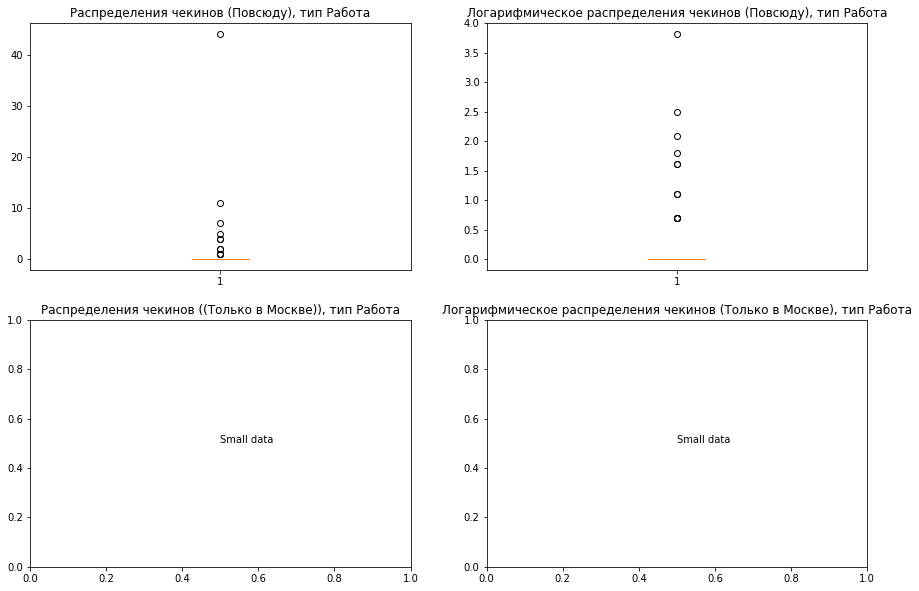

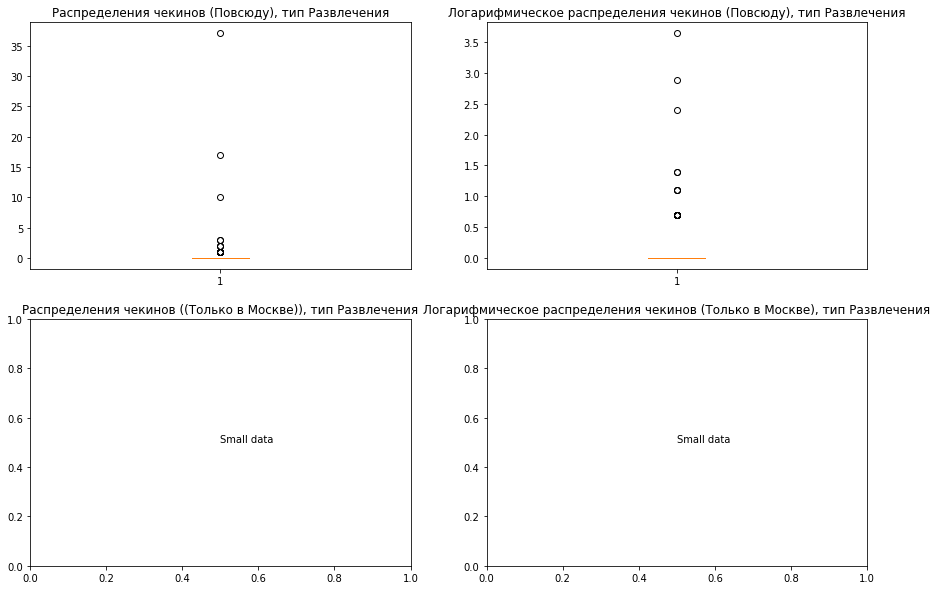

In [617]:
print("Распределение по типам")
for i in sorted(df['type'].unique(), key = lambda x:-len(df[df['type']==x])):
    temp = df[df['type']==i]['checkins'].get_values()
    if len(temp)<=40:
        continue
    place = places[i]
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
    ax1.set_title("Распределения чекинов (Повсюду), тип "+place)
    ax1.boxplot(temp)

    ax2.set_title("Логарифмическое распределения чекинов (Повсюду), тип "+place)
    ax2.boxplot(np.log(np.array(1.0+temp, dtype = 'float')))

    temp = df[(df['type']==i) & (df['city'] == 1)]['checkins'].get_values()
    
    ax3.set_title("Распределения чекинов ((Только в Москве)), тип "+place)
    ax4.set_title("Логарифмическое распределения чекинов (Только в Москве), тип "+place)


    if len(temp)<=10:
        ax3.text(0.5,0.5,"Small data")
        ax4.text(0.5,0.5,"Small data")
        continue

    ax3.boxplot(temp)
    ax4.boxplot(np.log(np.array(1.0+temp, dtype = 'float')))
    plt.show()
    print()

<h1><center>5. Преобразем поле created в datetime.  </center></h1>
<h1><center>Узнаем, как давно они были созданы? Сколько объектов существует больше года? </center></h1>


In [57]:
df['created_hf'] = [datetime.datetime.fromtimestamp(i) for i in df['created']]

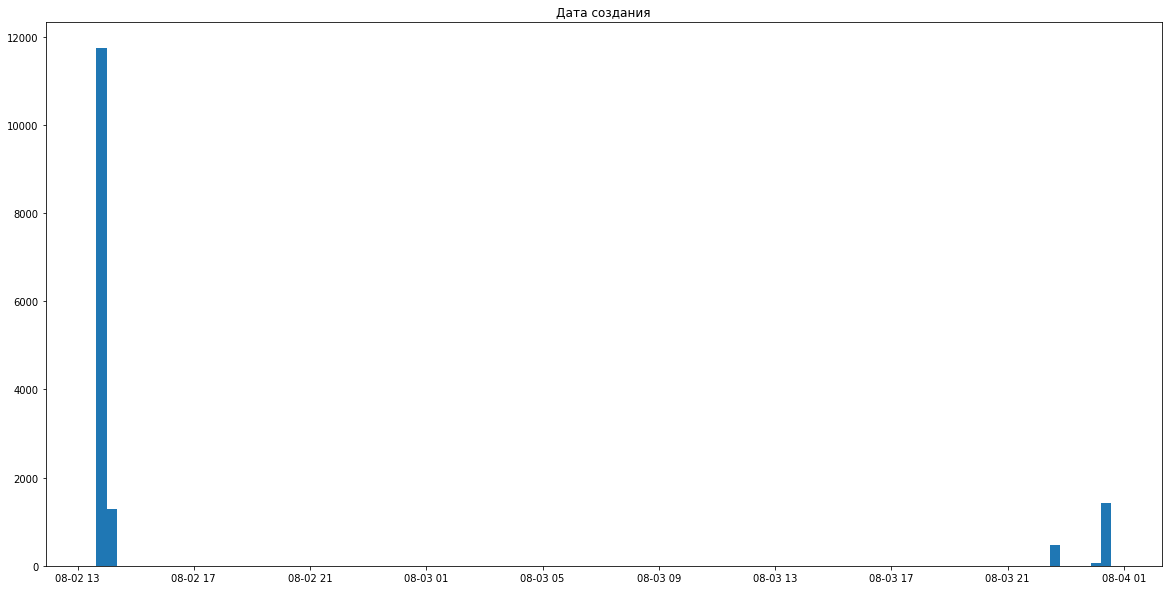

In [688]:
plt.figure(figsize = (20,10))
plt.title("Дата создания")
plt.hist(df['created_hf'].get_values(), bins = 100)
plt.show()

In [652]:
print("Самый старый :\t"+str(datetime.datetime.fromtimestamp(min(df['created']))))
print("Самый молодой:\t"+str(datetime.datetime.fromtimestamp(max(df['created']))))

Самый старый :	2010-08-02 13:39:01
Самый молодой:	2010-08-04 00:33:14


In [58]:
df['updated_hf'] = [datetime.datetime.fromtimestamp(i) 
                    if not np.isnan(i) else 
                    datetime.datetime.fromtimestamp(k)  
                    for i,k in df[['updated','created']].get_values()
                   ]

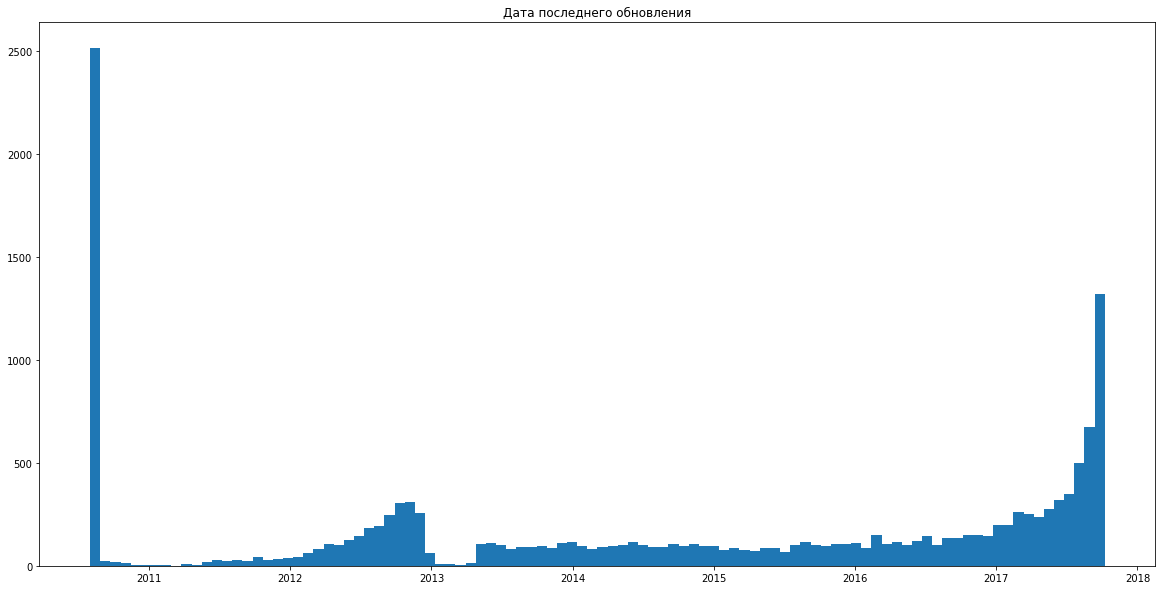

In [59]:
plt.figure(figsize = (20,10))
plt.title("Дата последнего обновления")
plt.hist(df['updated_hf'].get_values(), bins = 100)
plt.show()

In [60]:
df['not_updated'] = [np.isnan(i) for i in df['updated']]

In [61]:
print("Места которые никогда не обновлялись \t"+str(len(df[df['not_updated']])))
print('Суммарное количество их чекинов\t'+str(sum(df[df['not_updated']]['checkins'])))

Места которые никогда не обновлялись 	2279
Суммарное количество их чекинов	0


## Выводы
1. Id присваивались в порядке создания места (дата создания vk rest api, примерно 2010 год) . Поэтому все записи в выборке старые им больше 7 лет

2. В 2013 почему-то все начали отказываться от обновления мест

In [62]:
df.to_csv('vk_place_data.csv')